# Setup

In [6]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

# from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import itertools
from random import randint

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors   
import numpy as np
import os

import shap
import cv2

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

from exmatchina import *

In [7]:
num_classes = 5

classes = ['Non-ecotic beats (normal beat)', 
           'Supraventricular ectopic beats', 
           'Ventricular ectopic beats', 
           'Fusion beats', 
           'Unknown beats']


class_dict = {
    'Non-ecotic beats (normal beat)': 0,
    'Supraventricular ectopic beats': 1,
    'Ventricular ectopic beats': 2,
    'Fusion beats': 3,
    'Unknown beats': 4
}

inv_class_dict = {v: k for k, v in class_dict.items()}

## These are the randomly generated indices that were used in our survey

# all_idx = np.array([   86,   228,   692,  1157,  1244,  1264,  1656,  2432,  2777,
#         2925,  3016,  3108,  3167,  3335,  4184,  4607,  4723,  4999,
#         5840,  6081,  6123,  6130,  6206,  6228,  6294,  6515,  6567,
#         6598,  6726,  6877,  6973,  7033,  7410,  7426,  7540,  8042,
#         8220,  8439,  8609,  8766,  8855,  9437,  9442,  9517,  9719,
#        10026, 10345, 10511, 10588, 10623, 10807, 11290, 11367, 11909,
#        12009, 12088, 12534, 12760, 12986, 13311, 13352, 13477, 13561,
#        13659, 13904, 14087, 14257, 14455, 14596, 14852, 14962, 15103,
#        15715, 15820, 16830, 16860, 17142, 17154, 17356, 17382, 17451,
#        17520, 17845, 17882, 17944, 18354, 18557, 18630, 18666, 19032,
#        19199, 19531, 19932, 20399, 20618, 20636, 20782, 20844, 20849,
#        21857])

all_idx = [86,   228,   692,  1157,  1244]      #Considering just 5 samples

In [9]:
x_train = np.load('../data/ecg/X_train.npy')
y_train0 = np.load('../data/ecg/y_train.npy')
x_test = np.load('../data/ecg/X_test.npy')
y_test0 = np.load('../data/ecg/y_test.npy')

y_train = to_categorical(y_train0, num_classes)
y_test = to_categorical(y_test0, num_classes)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(87554, 186, 1)
(87554, 5)
(21892, 186, 1)
(21892, 5)


In [10]:
model = load_model('../trained_models/ecg.hdf5')
model.summary()

2025-07-04 16:15:39.507532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-04 16:15:44.037113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41088 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-07-04 16:15:44.040374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 40794 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:23:00.0, compute capability: 8.6
2025-07-04 16:15:44.043309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 186, 1)]          0         
                                                                 
 Conv1 (Conv1D)              (None, 181, 64)           448       
                                                                 
 Bn1 (BatchNormalization)    (None, 181, 64)           256       
                                                                 
 Mp1 (MaxPooling1D)          (None, 91, 64)            0         
                                                                 
 Drop1 (Dropout)             (None, 91, 64)            0         
                                                                 
 Conv2 (Conv1D)              (None, 89, 64)            12352     
                                                                 
 Bn2 (BatchNormalization)    (None, 89, 64)            256 

In [ ]:
def calculate_metrics(model, X_test, y_test_binary):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test_binary, axis=1)
    mismatch = np.where(y_true != y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return cf_matrix, accuracy, macro_f1, mismatch, y_pred

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        # print(cm)
    else:
        print('Confusion matrix, without normalization')
        # print(cm)

    plt.figure(figsize = (11,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize = 15)
    plt.yticks(tick_marks, classes, fontsize = 15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
  

In [12]:
cf_matrix, accuracy, macro_f1, mismatch, y_pred = calculate_metrics(model, x_test, y_test)
print('Accuracy : {}'.format(accuracy))
print('F1-score : {}'.format(macro_f1))

plot_confusion_matrix(cf_matrix, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

2025-07-04 16:15:49.778647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2025-07-04 16:15:50.869582: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2025-07-04 16:15:50.872356: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-07-04 16:15:50.872369: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2025-07-04 16:15:50.872451: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

 73/685 [==>...........................] - ETA: 1s

2025-07-04 16:15:51.616022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


685/685 [==============================] - 5s 2ms/step
Accuracy : 0.9759729581582313
F1-score : 0.8753428392232585
Normalized confusion matrix


# SHAP

In [22]:
import tensorflow.keras.backend as K
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# def map2layer(x, layer):
#     feed_dict = dict(zip([model.layers[0].input], x.reshape((1,) + x.shape)))
#     return K.get_session().run(model.layers[layer].input, feed_dict)
def map2layer(x, layer):
    if x.ndim == 3:  # (batch, 186, 1)
        x_in = x
    elif x.ndim == 2:  # (186, 1)
        x_in = np.expand_dims(x, axis=0)
    else:
        raise ValueError(f'Unexpected input shape: {x.shape}')
    
    func = K.function([model.input], [model.layers[layer].input])
    return func([x_in])[0]
    
def get_shap_full():
    e = shap.GradientExplainer(model, background)
    shap_values = e.shap_values(to_explain, ranked_outputs=2)
    shap.image_plot(shap_values, to_explain, width=5000, hspace='auto')


In [23]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((0/255,255/255,255/255,l))
for l in np.linspace(0,1,100):
    colors.append((255/255,0/255,255/255,l))
cmm = matplotlib.colors.LinearSegmentedColormap.from_list("shap", colors)

def plot_shap(idx):
    
    layer = 9
    to_explain = np.expand_dims(x_test[idx], axis=0)
    class_pred = np.argmax(model.predict(to_explain))
    print(class_pred)
    
    e = shap.GradientExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(background, layer))
    shap_values,indexes = e.shap_values(map2layer(to_explain, layer), ranked_outputs=1)

    abs_vals = np.stack(np.abs(shap_values[0].sum(-1)), 0).flatten()
    max_val = np.nanpercentile(abs_vals, 99.9)

    shap_values = cv2.resize(shap_values[0][0].sum(-1), (1,186))
    shap_values = shap_values.reshape((186,1))

    fig, ax = plt.subplots(ncols=2, figsize=(12,5))

    ax[0].plot(x_test[idx, :, 0], color='black')

    ax[1].plot(x_test[idx,:,0], color='black')

    gradient = shap_values[:,0]
    max_g = np.amax(gradient)
    min_g = np.amin(gradient)
    gradient = (gradient - min_g)/ (max_g - min_g)

    for j in range(len(gradient)):
        current_color = cmm(gradient[j])
        ax[1].axvspan(j, j+1, facecolor=current_color)   

    sm = cm.ScalarMappable(cmap=cmm)
    sm.set_clim(-max_val,max_val)

    cb = fig.colorbar(sm, ax=ax.ravel().tolist(), label="SHAP value", aspect=60)
    cb.outline.set_visible(False)

    # plt.savefig('./ecg/ecg-' + str(idx) + '-shap.png', bbox_inches='tight')
    # plt.close(fig)
    plt.show()

1/1 [==============================] - 0s 46ms/step
3


/home/kwakrhkr59/anaconda3/envs/clean/lib/python3.10/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


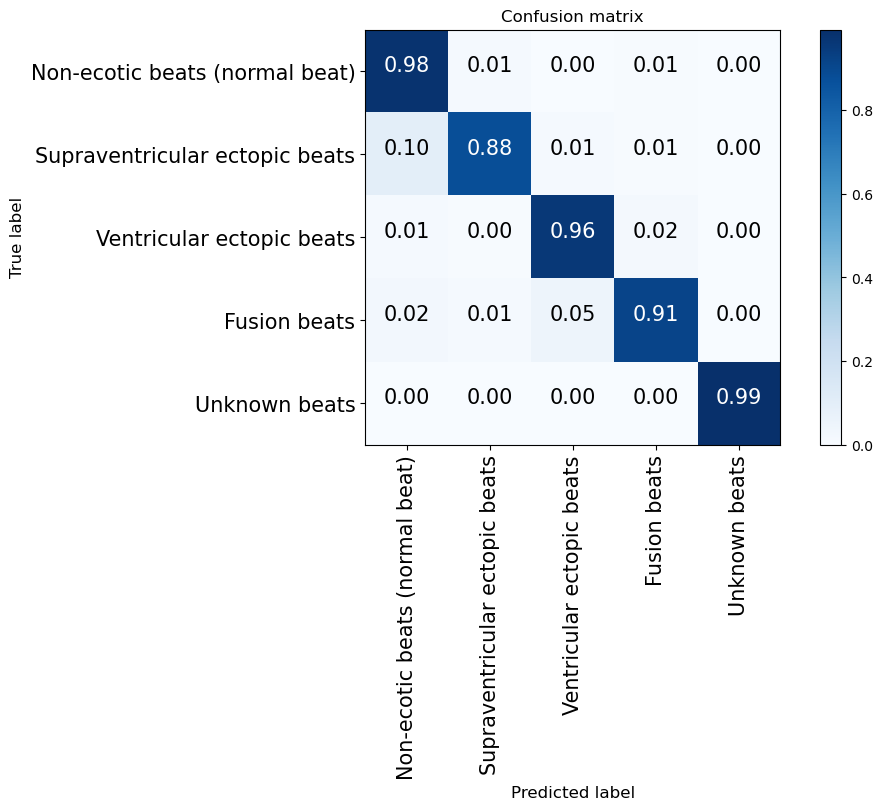

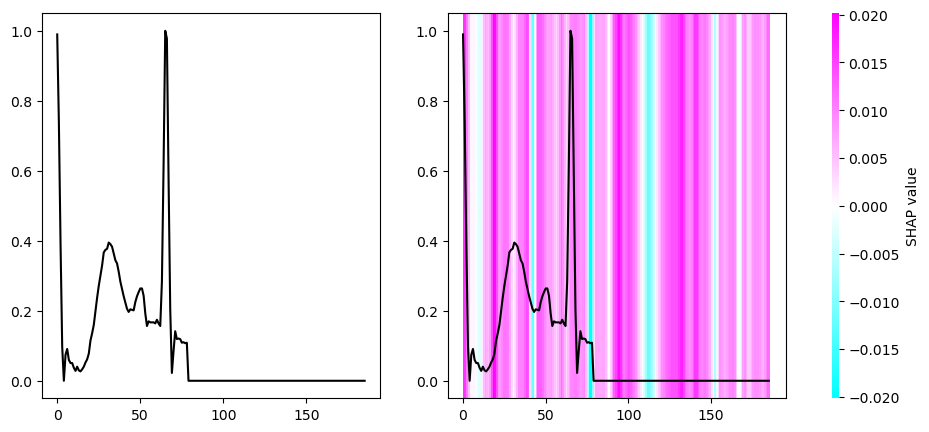

1/1 [==============================] - 0s 42ms/step
0


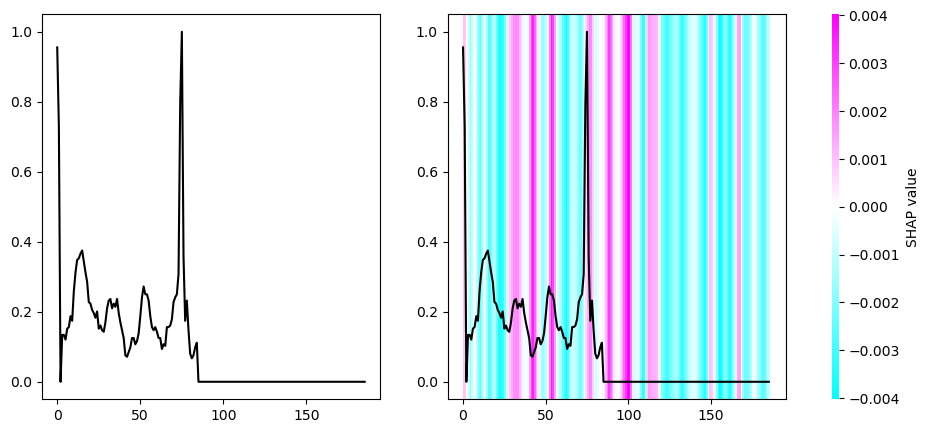

1/1 [==============================] - 0s 43ms/step
0


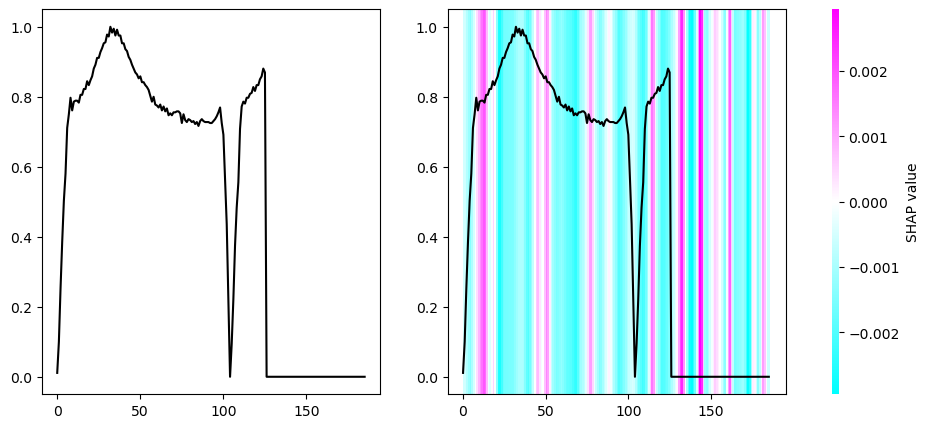

1/1 [==============================] - 0s 43ms/step
0


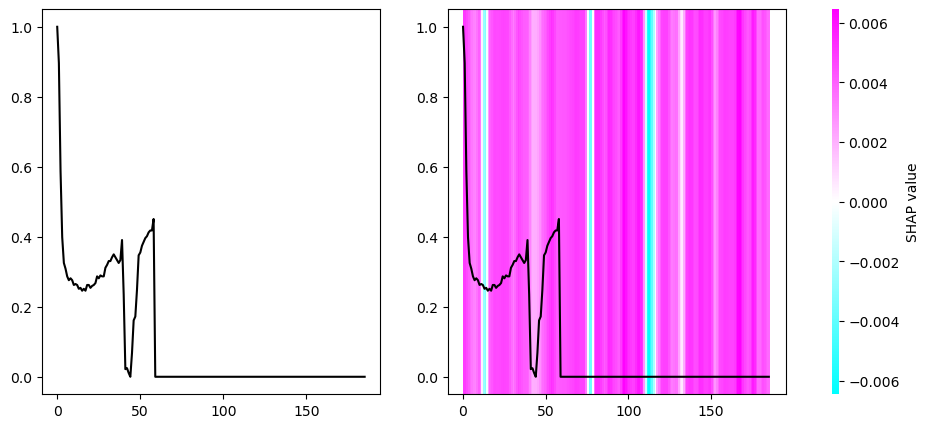

1/1 [==============================] - 0s 43ms/step
0


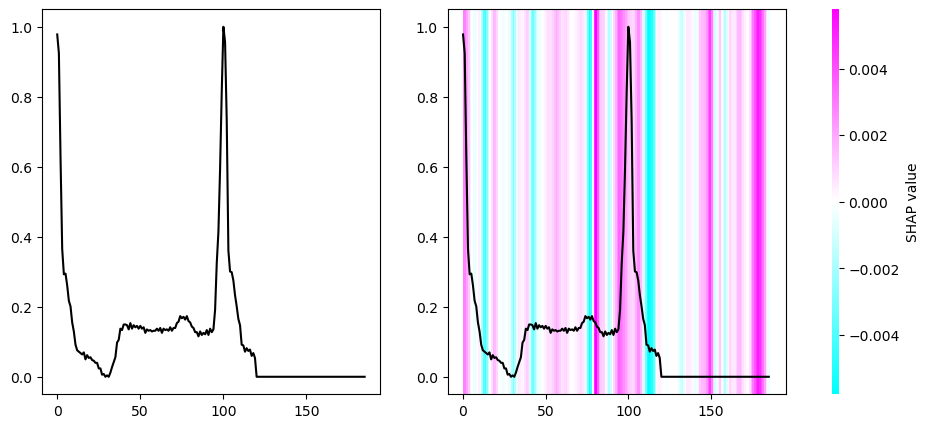

In [24]:
for i in all_idx:
    plot_shap(i)

# Saliency Map

In [25]:
# Saliency map requires the logits
new_model = Model(inputs=model.input,
                  outputs=model.get_layer("logits").output)

new_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 186, 1)]          0         
                                                                 
 Conv1 (Conv1D)              (None, 181, 64)           448       
                                                                 
 Bn1 (BatchNormalization)    (None, 181, 64)           256       
                                                                 
 Mp1 (MaxPooling1D)          (None, 91, 64)            0         
                                                                 
 Drop1 (Dropout)             (None, 91, 64)            0         
                                                                 
 Conv2 (Conv1D)              (None, 89, 64)            12352     
                                                                 
 Bn2 (BatchNormalization)    (None, 89, 64)            256

In [26]:
def plot_map(idx, class_pred, grads):
    
    print(inv_class_dict[class_pred])
    fig, ax = plt.subplots(ncols=2, figsize=(8,4))
    
    ax[0].plot(x_test[idx, :, 0], color='black')
    ax[1].plot(x_test[idx, :, 0], color='black')

    gradient = grads
    max_g = np.amax(gradient)
    min_g = np.amin(gradient)
    gradient = (gradient - min_g)/ (max_g - min_g)

    for i in range(len(gradient)):
        current_color = cm.cool(gradient[i])
        ax[1].axvspan(i, i+1, facecolor=current_color, alpha=0.7)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.75])
    fig.colorbar(cm.ScalarMappable(cmap="cool"), cbar_ax, alpha=0.8)
    
    # plt.savefig('./ecg/ecg-' + str(idx) + '-saliencymap.png', bbox_inches='tight')
    # plt.close(fig)
    plt.show()

In [29]:
# def getSaliencyMap(idx):

#     to_explain = np.expand_dims(x_test[idx],axis=0)
#     class_pred = np.argmax(model.predict(to_explain))
#     grads = visualize_saliency(new_model,
#                                 9,
#                                 filter_indices = None,
#                                 seed_input = x_test[idx])
#     plot_map(idx, class_pred , grads)
def getSaliencyMap(idx):
    to_explain = np.expand_dims(x_test[idx], axis=0)
    class_pred = np.argmax(model.predict(to_explain))

    score = CategoricalScore([class_pred])
    modifier = ReplaceToLinear()

    saliency = Saliency(model, model_modifier=modifier)
    saliency_map = saliency(score, to_explain)

    # shape: (1, 186, 1) or (1, 186) depending on model
    saliency_map = saliency_map[0]
    if saliency_map.ndim == 2 and saliency_map.shape[1] == 1:
        saliency_map = saliency_map.reshape(-1)

    plot_map(idx, class_pred, saliency_map)

1/1 [==============================] - 0s 43ms/step
Fusion beats


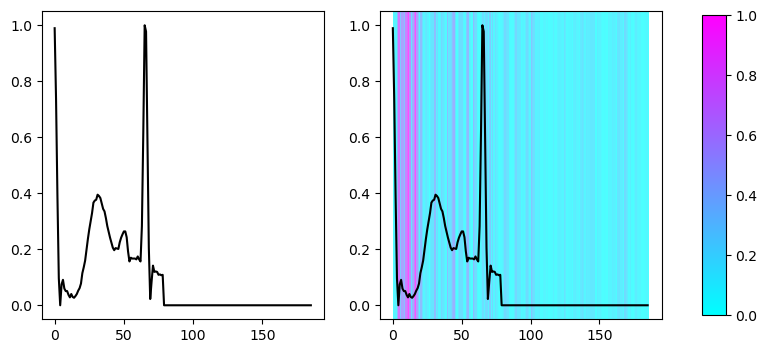

1/1 [==============================] - 0s 43ms/step
Non-ecotic beats (normal beat)


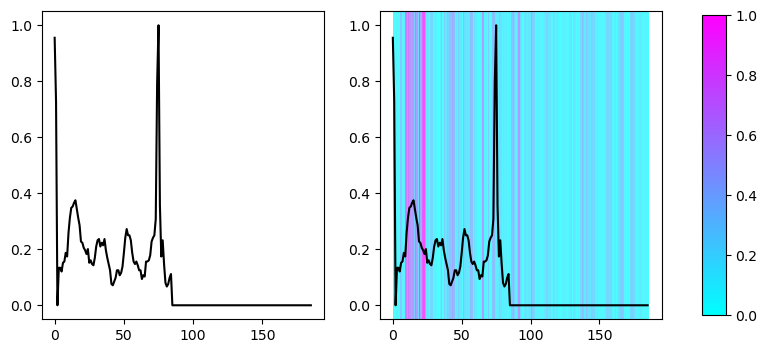

1/1 [==============================] - 0s 43ms/step
Non-ecotic beats (normal beat)


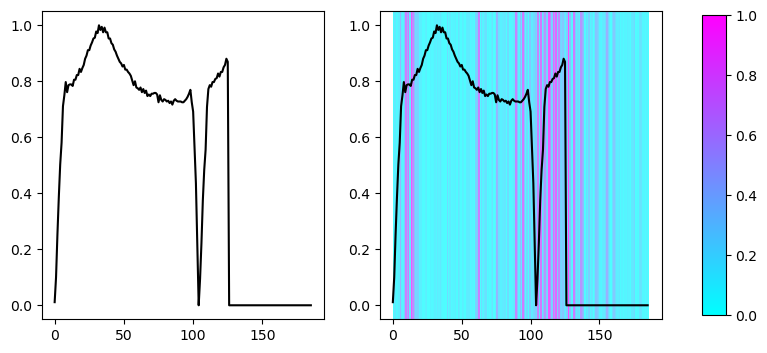

1/1 [==============================] - 0s 44ms/step
Non-ecotic beats (normal beat)


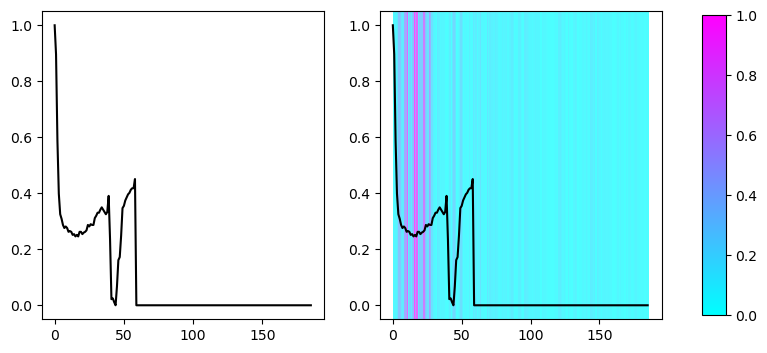

1/1 [==============================] - 0s 43ms/step
Non-ecotic beats (normal beat)


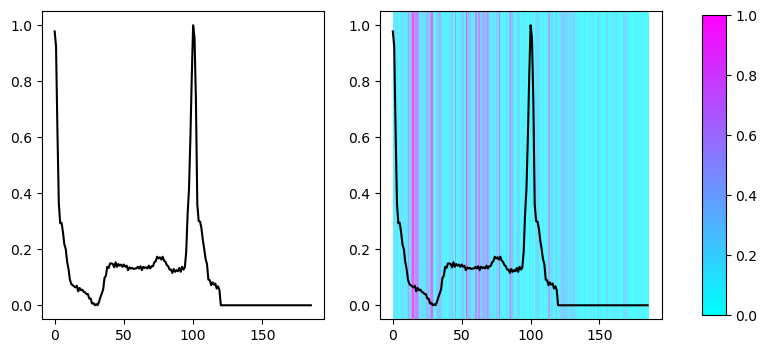

In [30]:
for i in all_idx:
    getSaliencyMap(i)

# GradCam++

In [34]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def plot_cam(idx, cls_pred, heatmap):
    
    print(inv_class_dict[cls_pred])

    fig, ax = plt.subplots(ncols=2, figsize=(8,4))

    ax[0].plot(x_test[idx, :, 0], color='black')
    ax[1].plot(x_test[idx, :, 0], color='black')

    gradient = heatmap.reshape((186,))
    max_g = np.amax(gradient)
    min_g = np.amin(gradient)
    gradient = (gradient - min_g)/ (max_g - min_g)

    for i in range(len(gradient)):
        current_color = cm.cool(gradient[i])
        ax[1].axvspan(i, i+1, facecolor=current_color, alpha=0.7)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.75])
    fig.colorbar(cm.ScalarMappable(cmap="cool"), cbar_ax, alpha=0.8)

    # plt.savefig('./ecg/ecg-' + str(idx) + '-gradcampp.png', bbox_inches='tight')
    # plt.close(fig)
    plt.show()

# def get_gradcampp(idx):
#     img = x_test[idx]
#     class_idx = np.argmax(y_test[idx])
    
#     x = np.expand_dims(img, axis=0)

#     cls_pred, cam = grad_cam_plus_plus(input_model=model, x=x, layer_name="Conv3")
#     heatmap = cv2.resize(cam, (1,186))
#     heatmap = heatmap.reshape((186,1))

#     plot_cam(idx,cls_pred, heatmap)
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

def get_gradcampp(idx):
    img = x_test[idx]
    x = np.expand_dims(img, axis=0)

    class_idx = np.argmax(model.predict(x))  # 예측된 클래스 인덱스
    score = CategoricalScore([class_idx])    # tf-keras-vis용 score 함수

    gradcampp = GradcamPlusPlus(model, model_modifier=ReplaceToLinear())
    cam = gradcampp(score, x, penultimate_layer='Conv3')  # Conv3: 마지막 Conv 레이어 이름

    # cam.shape: (1, 186, 1) → (186, 1)
    heatmap = cam[0].squeeze()
    if heatmap.ndim == 1:
        heatmap = heatmap.reshape((186, 1))

    plot_cam(idx, class_idx, heatmap)


def grad_cam_plus_plus(input_model, x, layer_name):
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = normalize(K.gradients(y_c, conv_output)[0])

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[1])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[1]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))

    alphas = alpha_num / alpha_denom # 0

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) # 0
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[1])) # NAN
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[1])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=1)

    cam = np.maximum(cam, 0)
    if cam.max() == 0:
        print(idx)
    cam /= cam.max()

    return cls, cam

1/1 [==============================] - 0s 44ms/step
Fusion beats


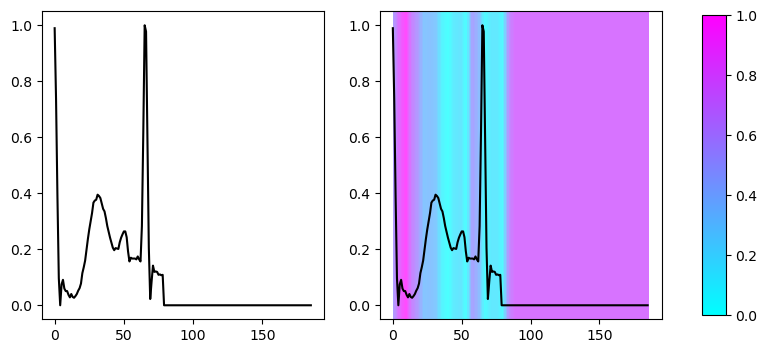

1/1 [==============================] - 0s 42ms/step
Non-ecotic beats (normal beat)


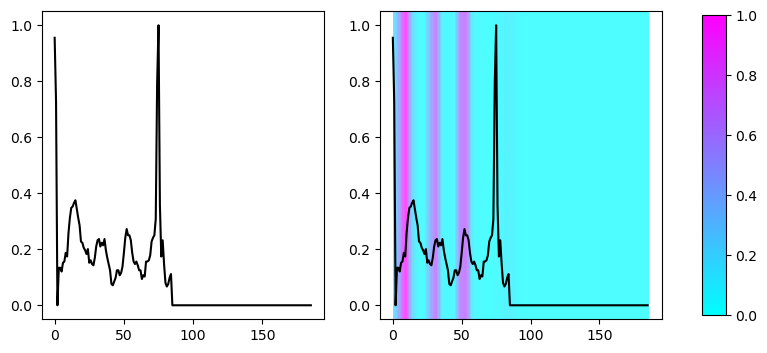

1/1 [==============================] - 0s 43ms/step
Non-ecotic beats (normal beat)


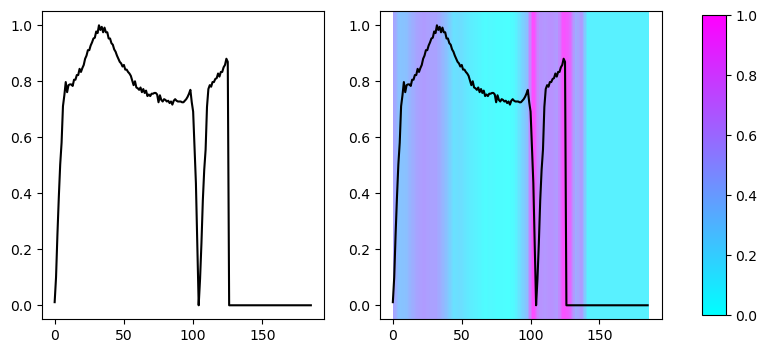

1/1 [==============================] - 0s 43ms/step
Non-ecotic beats (normal beat)


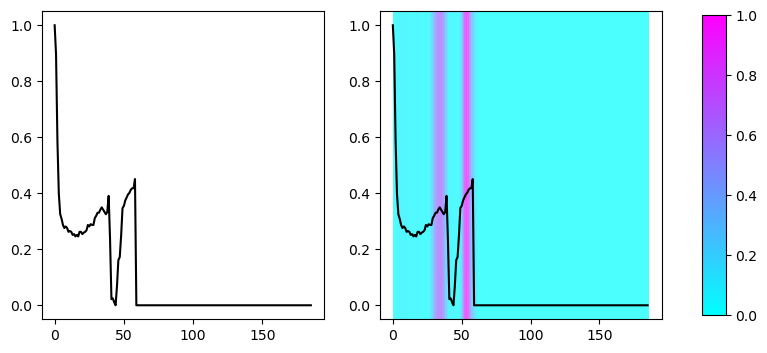

1/1 [==============================] - 0s 55ms/step
Non-ecotic beats (normal beat)


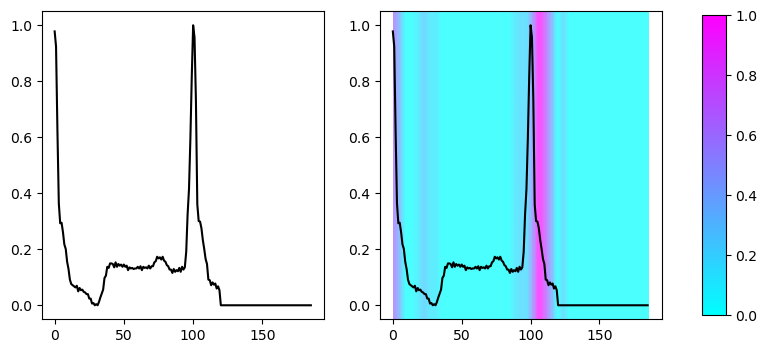

In [35]:
for i in all_idx:
    get_gradcampp(i)

# ExMatchina

In [36]:
def plot_ecg(test, examples, label):
        # =======GENERATE STUDY EXAMPLES=========
    fig = plt.figure(figsize=(14,5))
    num_display = 4
    fig.add_subplot(1, num_display, 1).title.set_text(inv_class_dict[label])
    plt.plot(test)
   # plt.axis('off')
    line = fig.add_subplot(1, 1, 1)
    line.plot([2.39,2.39],[0,1],'--')
    line.set_xlim(0,10)
    line.axis('off')
    for k in range(num_display-1):
        if k >= len(examples):
            continue
        fig.add_subplot(1,num_display,k+2).title.set_text(inv_class_dict[label])
        fig.add_subplot(1,num_display,k+2).title.set_color('#0067FF')
        plt.plot(examples[k])
       # plt.axis('off')
    
    fig.tight_layout()
    plt.tight_layout()
    plt.show()
    # plt.savefig('./image-' + str(i) + '-example.png', bbox_inches='tight')

In [37]:
selected_layer = 'Flatten'

exm = ExMatchina(model=model, layer=selected_layer, examples=x_train)

Getting activations...
2737/2737 [==============================] - 5s 2ms/step
Getting labels...
2737/2737 [==============================] - 6s 2ms/step
Generating activation matrix...


1/1 [==============================] - 0s 131ms/step


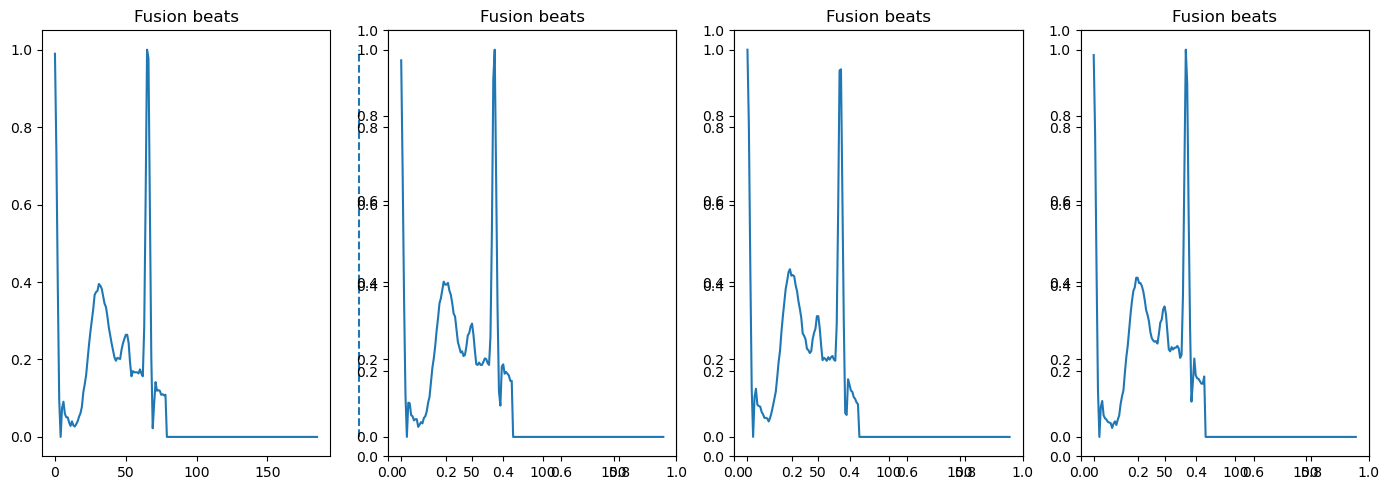

1/1 [==============================] - 0s 125ms/step


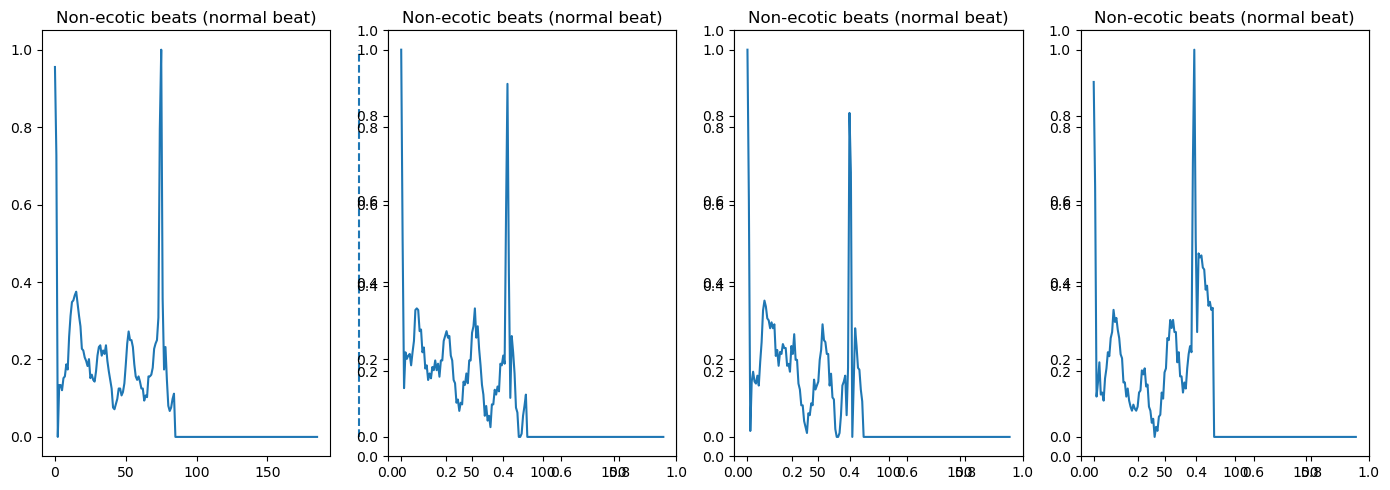

1/1 [==============================] - 0s 127ms/step


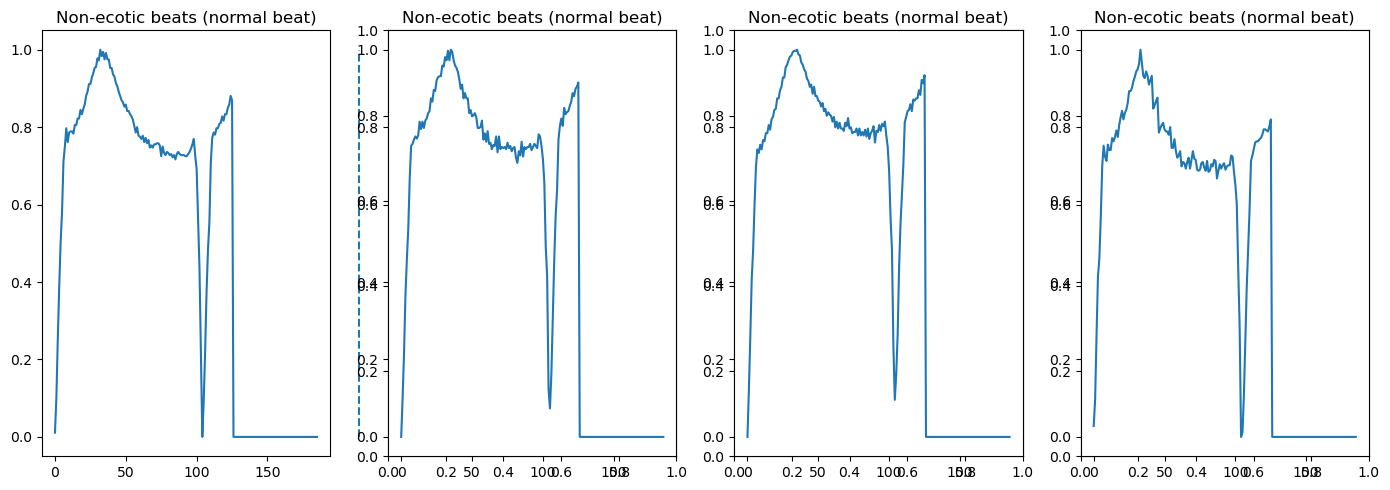

1/1 [==============================] - 0s 126ms/step


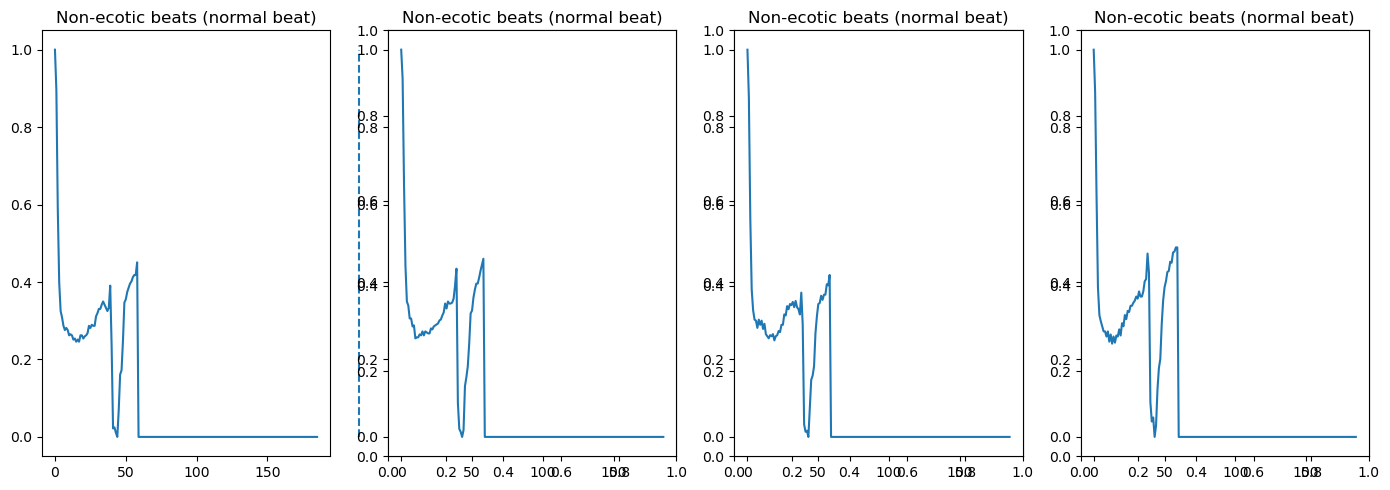

1/1 [==============================] - 0s 127ms/step


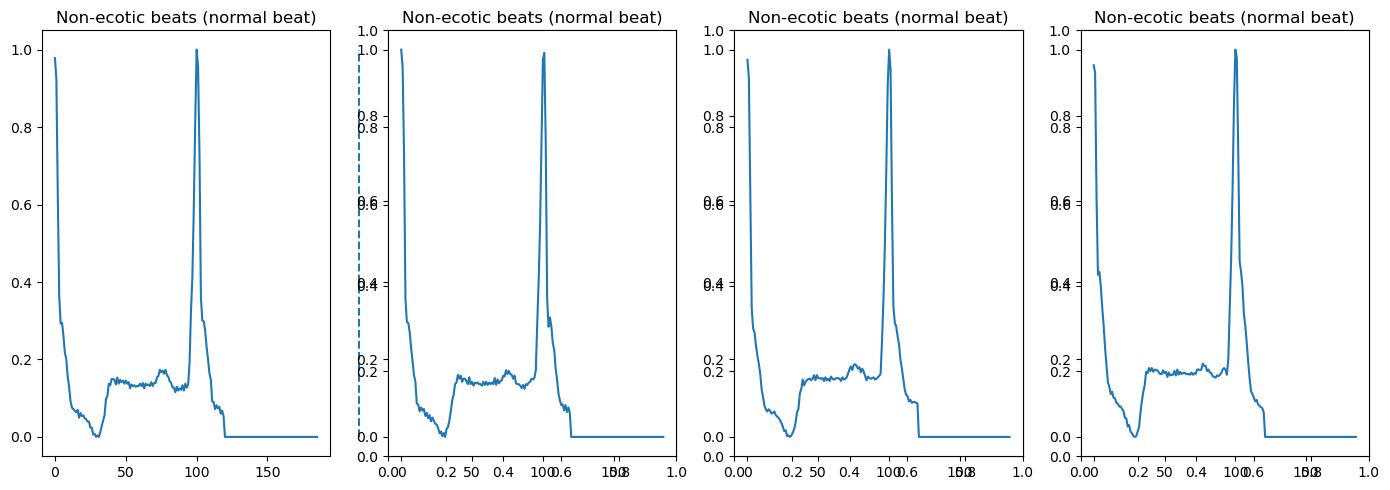

In [38]:
for test_idx in all_idx:
    test_input = x_test[test_idx]
    label = exm.get_label_for(test_input)
    (examples, indices) = exm.return_nearest_examples(test_input)
    plot_ecg(test_input, examples, label)